# Text Classification

## Agenda

1. Represent text as numerical data
2. Read text dataset into pandas
3. Vectorize text dataset ( using both CountVectorizer and TFIDFVectorizer )
4. Build and evaluate a model
5. Compare multiple models
6. Fine tune vectorizer
7. Word cloud
8. Lemmatization and stemming
9. Sentiment calculation

## 1: Represent text as numerical data

In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Sample text data
sampleTrain = ['i will call you tonight', 'please help me...', 'Please call a cab please !']

In [3]:
# sample target vector
y = [0, 1, 0]

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
toNumeric = CountVectorizer()

In [5]:
#Get the vocabulary(unique words) from training data
toNumeric.fit(sampleTrain)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [6]:
# Test the created vocabulary
toNumeric.get_feature_names()

['cab', 'call', 'help', 'me', 'please', 'tonight', 'will', 'you']

In [7]:
sampleTrain = ['i will call you tonight', 'please help me...', 'Please call a cab please !']

In [8]:
# Convert training data into a 'document-term matrix'
sampleTrain_dtm = toNumeric.transform(sampleTrain)
sampleTrain_dtm

<3x8 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [9]:
# Let's convert sparse matrix to a dense matrix
sampleTrain_dtm.toarray()

array([[0, 1, 0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 2, 0, 0, 0]], dtype=int64)

In [10]:
pd.DataFrame(sampleTrain_dtm.toarray(), columns=toNumeric.get_feature_names())

,cab,call,help,me,please,tonight,will,you
0,0,1,0,0,0,1,1,1
1,0,0,1,1,1,0,0,0
2,1,1,0,0,2,0,0,0


In [11]:
# Build a model to predict the target
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(sampleTrain_dtm, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [12]:
# Test text for model validation
sampleTest = ["Don't call please"]

In order to make a prediction, the new test data must have the same features as the training observations, both in number and meaning.

In [13]:
# Transform test data into DTM by using generated vocabulary
sampleTest_dtm = toNumeric.transform(sampleTest)
sampleTest_dtm.toarray()

array([[0, 1, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [14]:
# Test built model
knn.predict(sampleTest_dtm)

array([0])

**Summary:**

- `vect.fit(sampleTrain)` **learn the vocabulary** from training data
- `vect.transform(sampleTrain)` use the **trained vocabulary** to build DTM from the train data
- `vect.transform(sampleTest)` use the **trained vocabulary** to build a DTM from the test data and **ignore vocabulary** it hasn't seen before

## 2. Read text dataset into pandas

In [15]:
# Read sms data into pandas
data = pd.read_table('sms.tsv', header=None, names=['label', 'message'])

In [16]:
data.shape

(5572, 2)

In [17]:
data.head(5)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
# Target variable 'label' is categorical. Convert it into numeric value
data['label_num'] = data.label.map({'ham':0, 'spam':1})

In [19]:
data.head(5)

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [20]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [21]:
# Define X and y data sets from'data'
X = data.message
y = data.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

##  3. Vectorize text dataset

In [23]:
# call the vectorizer
toNumeric = CountVectorizer()

In [24]:
# creat vocabulary and create document-term matrix
toNumeric.fit(X_train)
X_train_dtm = toNumeric.transform(X_train)

In [25]:
X_train_dtm

<4179x7535 sparse matrix of type '<class 'numpy.int64'>'
	with 56144 stored elements in Compressed Sparse Row format>

In [26]:
# transform test data using fitted vocabulary into DTM
X_test_dtm = toNumeric.transform(X_test)
X_test_dtm

<1393x7535 sparse matrix of type '<class 'numpy.int64'>'
	with 16754 stored elements in Compressed Sparse Row format>

## 4. Build and evaluate a model

In [27]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [28]:
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
y_pred_class = nb.predict(X_test_dtm)

In [30]:
# Accuracy calculation
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9820531227566404

In [31]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[1194,    7],
       [  18,  174]], dtype=int64)

In [32]:
# Predict probablity for test data instead of labels directly
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([3.11305286e-06, 2.45568879e-06, 3.66677804e-04, ...,
       9.28339673e-01, 4.13005037e-01, 1.36208930e-07])

In [33]:
# Calculate AUC-ROC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9922894116014432

## 5. Compare multiple models

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [35]:
lr.fit(X_train_dtm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
y_pred_class = lr.predict(X_test_dtm)

In [37]:
# calculate predicted probabilities for X_test_dtm
y_pred_prob = lr.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.0062285 , 0.01911204, 0.00453425, ..., 0.50834525, 0.96176089,
       0.00344967])

In [38]:
metrics.accuracy_score(y_test, y_pred_class)

0.9798994974874372

In [39]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9951819664168748

## 6. Fine tune vectorizer

In [40]:
# Default parameters for CountVectorizer
toNumeric = CountVectorizer()
toNumeric

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [41]:
# Remove English stop words
toNumeric = CountVectorizer(stop_words='english')
toNumeric.fit(X_train)
len(toNumeric.get_feature_names())

7271

In [42]:
# Include 1 and 2-grams
toNumeric = CountVectorizer(ngram_range=(1, 2))
toNumeric.fit(X_train)
len(toNumeric.get_feature_names())

41571

In [43]:
# Ignore terms that appear in more than 75% of the documents
toNumeric = CountVectorizer(max_df=0.75)
toNumeric.fit(X_train)
len(toNumeric.get_feature_names())

7535

In [44]:
# Keep terms that appear in at least 5 documents
toNumeric = CountVectorizer(min_df=2)
toNumeric.fit(X_train)
len(toNumeric.get_feature_names())

3527

## 7. Word Cloud

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

In [50]:
data.head(5)

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


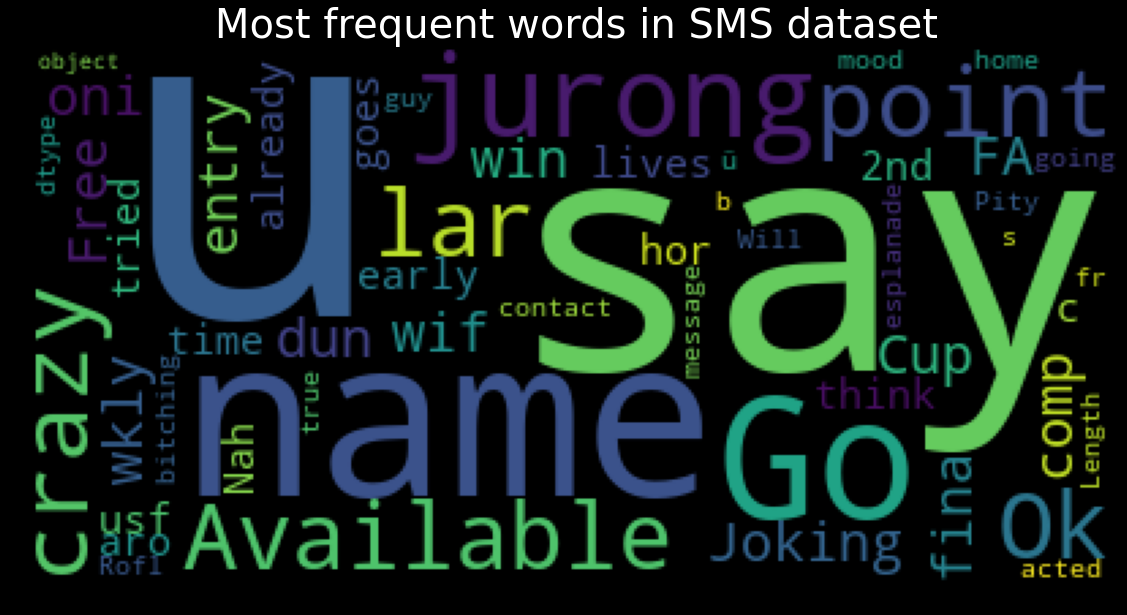

In [51]:
wc = WordCloud()
wc.generate(str(data['message']))
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Most frequent words in SMS dataset", fontsize=40,color='white')
plt.imshow(wc)
plt.show()

## 8.  Lemmatization and stemming

In [52]:
import nltk

In [53]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sanjana\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [54]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

In [55]:
#create an object of class PorterStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()

#### PorterStemmer

- It uses set of rules to decide whether it is wise to strip a suffix. 
- Quite often does not generate words which are in dictionary.
- PorterStemmer is known for its simplicity and speed. 

In [56]:
#proide a word to be stemmed
print(porter.stem("cats"))
print(porter.stem("trouble"))
print(porter.stem("troubling"))
print(porter.stem("troubled"))

cat
troubl
troubl
troubl


### Sentence stemming

In [57]:
sentence="Pythoners are very intelligent and work very pythonly and now they are pythoning their way to success."
porter.stem(sentence)

'pythoners are very intelligent and work very pythonly and now they are pythoning their way to success.'

In [58]:
from nltk.tokenize import sent_tokenize, word_tokenize
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

x=stemSentence(sentence)
print(x)

python are veri intellig and work veri pythonli and now they are python their way to success . 


In [61]:
from textblob import TextBlob

In [62]:
sent = TextBlob(sentence)

In [63]:
print(' '.join([porter.stem(word) for word in sent.words]))

python are veri intellig and work veri pythonli and now they are python their way to success


## 9.  Sentiment calculation

In [64]:
from textblob import TextBlob

In [65]:
text = "I hate anything that goes in my ear"

In [66]:
result = TextBlob(text)

In [67]:
result.sentiment.polarity

-0.8